In [1]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Инициализация модели

In [2]:
model = YOLO(r'yolov8m.pt')
model.fuse()

Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


Пути к папкам или файлам

In [3]:
employee_name = "Alimov"
docs_path = 'Docs'
employee_signs_path = 'Signatures/' 
predicts_signs_path = 'Predicts/Signs'
predicts_docs_path = 'Predicts/Docs'

# Добавление подписей сотрудника в базу

In [4]:
def add_employee_signatures(signature_folder, employee_name):
    counter = 1  # Счетчик для добавления номера к сохраняемым файлам
    employee_folder = os.path.join(signature_folder, employee_name)
    os.makedirs(employee_folder, exist_ok=True)
    
    for img_file in os.listdir(signature_folder):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):  
            # Загружаем изображение
            img_path = os.path.join(signature_folder, img_file)
            img = cv2.imread(img_path)
    
            results = model.predict(img, conf=0.19, iou=0.3, verbose=False) 
    
            for idx, result in enumerate(results):
                boxes = result.boxes.xyxy
                classes = result.boxes.cls.cpu().numpy()  
                for box, cls in zip(boxes, classes):
                    if cls == 1:  
                        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
                        # Вырезаем область с подписью из исходного изображения
                        signature_img = result.orig_img[int(y1):int(y2), int(x1):int(x2)]
                        # Сохраняем вырезанную подпись в отдельное изображение
                        save_path = os.path.join(employee_folder, f"{employee_name}_sign_{counter}.jpg")
                        cv2.imwrite(save_path, signature_img)
                        counter += 1
    
    print("Подписи успешно добавлены в папку сотрудника.")

In [5]:
add_employee_signatures(employee_signs_path, employee_name)

Подписи успешно добавлены в папку сотрудника.


# Выделение подписей в документах

In [8]:
def select_signatures_in_documents(docs_folder, predict_folder, box_color=(0, 0, 0)):
    os.makedirs(predict_folder, exist_ok=True)
    for docs_file in os.listdir(docs_folder):
        if docs_file.endswith('.jpg') or docs_file.endswith('.png'):
            img_path = os.path.join(docs_folder, docs_file)
            results = model.predict(img_path, conf=0.19, iou=0.3, verbose=False)
            save_path = os.path.join(predict_folder, docs_file)

            for idx, result in enumerate(results):
                img = result.orig_img.copy()  # Создаем копию исходного изображения

                # Перебираем прямоугольные рамки и классы
                for box, cls in zip(result.boxes.xyxy, result.boxes.cls.cpu().numpy()):
                    if cls == 1:  # Если класс объекта - подпись
                        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
                        # Рисуем контур рамки на изображении
                        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), box_color, thickness=2)

                # Сохраняем изображение с рамками
                cv2.imwrite(save_path, img)
    
    print("Подписи успешно выделены в документах.")


In [9]:
select_signatures_in_documents(docs_path, predicts_docs_path, box_color=(0, 0, 0))

Подписи успешно выделены в документах.


# Получение подписей из документов

In [10]:
def extract_signatures_from_documents(docs_path, predict_path):
    os.makedirs(predict_path, exist_ok=True)
    for img_file in os.listdir(docs_path):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            img_path = os.path.join(docs_path, img_file)
            results = model.predict(img_path, conf=0.19, iou=0.3, verbose=False) 
            base_name = os.path.splitext(os.path.basename(img_file))[0]  # Базовое имя файла без расширения
            counter = 1  # Счетчик для добавления номера к сохраняемым файлам
    
            for idx, result in enumerate(results):
                boxes = result.boxes.xyxy
                classes = result.boxes.cls.cpu().numpy()  # Метки классов для каждой области
                for box, cls in zip(boxes, classes):
                    if cls == 1:  # Если класс объекта - подпись
                        # Получаем координаты прямоугольной рамки
                        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
                        
                        # Вырезаем область с подписью из исходного изображения
                        signature_img = result.orig_img[int(y1):int(y2), int(x1):int(x2)]
                        
                        # Сохраняем вырезанную подпись в отдельное изображение
                        signature_save_path = os.path.join(predict_path, f'{base_name}_sign_{counter}.jpg')
                        cv2.imwrite(signature_save_path, signature_img)
                        counter += 1

    return "Подписи успешно получены из документов."


In [11]:
extract_signatures_from_documents(docs_path, predicts_signs_path)

Подписи успешно получены из документов.


# Визуальный вывод о сравнениях всех подписей

In [237]:
def visualize_comparisons_signature(employee_signatures_path, predicts_path):
    # Загружаем все подписи сотрудника 
    employee_signatures = []
    for filename in os.listdir(employee_signatures_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            signature_img = cv2.imread(os.path.join(employee_signatures_path, filename), cv2.IMREAD_GRAYSCALE)
            employee_signatures.append((filename, signature_img))

    # Загружаем все подписи из документов
    document_signatures = []
    for filename in os.listdir(predicts_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            signature_img = cv2.imread(os.path.join(predicts_path, filename), cv2.IMREAD_GRAYSCALE)
            document_signatures.append((filename, signature_img))

    # Создаем объект sift детектора
    sift = cv2.SIFT_create()

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50) 

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Пройдемся по каждому документу
    for doc_filename, doc_signature_img in document_signatures:
        # Находим keypoints и descriptors с помощью SIFT для queryImage
        kp1, des1 = sift.detectAndCompute(doc_signature_img, None)

        # Пройдемся по каждой подписи сотрудника
        for signature_filename, signature_img in employee_signatures:
            # Находим keypoints и descriptors с помощью SIFT для trainImage
            kp2, des2 = sift.detectAndCompute(signature_img, None)

            # Выполняем сопоставление между дескрипторами изображений
            matches = flann.knnMatch(des1, des2, k=2)

            # Необходимо отрисовать только хорошие совпадения, поэтому создадим маску
            matchesMask = [[0, 0] for _ in range(len(matches))]

            # Проверим соответствие по критерию Лоу
            good_matches = 0
            for i, (m, n) in enumerate(matches):
                if m.distance < 0.57 * n.distance:
                    matchesMask[i] = [1, 0]
                    good_matches += 1
            print(f"Для документа {doc_filename} и подписи {signature_filename}: Количество хороших совпадений: {good_matches}")

            # Отрисовываем только хорошие совпадения
            draw_params = dict(matchColor=(0, 255, 0),
                               singlePointColor=(255, 0, 0),
                               matchesMask=matchesMask,
                               flags=cv2.DrawMatchesFlags_DEFAULT)

            img3 = cv2.drawMatchesKnn(doc_signature_img, kp1, signature_img, kp2, matches, None, **draw_params)

            plt.imshow(img3)
            plt.title(f"Совпадения для документа {doc_filename} и подписи {signature_filename}")
            plt.show()

In [ ]:
visualize_comparisons_signature(employee_signs_path + employee_name, predicts_signs_path)

# Визуальный вывод о сравнениях только лучших совпадений подписей

In [12]:
def visualize_best_signatures(employee_signatures_path, predicts_path):
    # Загружаем все подписи сотрудника 
    employee_signatures = []
    for filename in os.listdir(employee_signatures_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            signature_img = cv2.imread(os.path.join(employee_signatures_path, filename), cv2.IMREAD_GRAYSCALE)
            employee_signatures.append((filename, signature_img))

    # Загружаем все подписи из документов
    document_signatures = []
    for filename in os.listdir(predicts_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            signature_img = cv2.imread(os.path.join(predicts_path, filename), cv2.IMREAD_GRAYSCALE)
            document_signatures.append((filename, signature_img))

    # Создаем объект sift детектора
    sift = cv2.SIFT_create()

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50) 

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Пройдемся по каждому документу
    for doc_filename, doc_signature_img in document_signatures:
        # Находим keypoints и descriptors с помощью SIFT для queryImage
        kp1, des1 = sift.detectAndCompute(doc_signature_img, None)

        # Переменные для отслеживания наилучшего соответствия
        best_signature_filename = None
        best_good_matches = 0
        best_matchesMask = []

        # Пройдемся по каждой подписи сотрудника
        for signature_filename, signature_img in employee_signatures:
            # Находим keypoints и descriptors с помощью SIFT для trainImage
            kp2, des2 = sift.detectAndCompute(signature_img, None)

            # Выполняем сопоставление между дескрипторами изображений
            matches = flann.knnMatch(des1, des2, k=2)

            # Необходимо отрисовать только хорошие совпадения, поэтому создадим маску
            matchesMask = [[0, 0] for _ in range(len(matches))]

            # Проверим соответствие по критерию Лоу
            good_matches = 0
            for i, (m, n) in enumerate(matches):
                if m.distance < 0.57 * n.distance:
                    matchesMask[i] = [1, 0]
                    good_matches += 1

            # Обновляем переменные, если текущая подпись имеет больше хороших совпадений
            if good_matches > best_good_matches:
                best_signature_filename = signature_filename
                best_good_matches = good_matches
                best_matchesMask = matchesMask

        # Отображаем только лучшие совпадения
        if best_signature_filename is not None and best_good_matches >= 10:
            signature_img = cv2.imread(os.path.join(employee_signatures_path, best_signature_filename), cv2.IMREAD_GRAYSCALE)
            kp2, des2 = sift.detectAndCompute(signature_img, None)
            matches = flann.knnMatch(des1, des2, k=2)

            draw_params = dict(matchColor=(0, 255, 0),
                               singlePointColor=(255, 0, 0),
                               matchesMask=best_matchesMask,
                               flags=cv2.DrawMatchesFlags_DEFAULT)

            img3 = cv2.drawMatchesKnn(doc_signature_img, kp1, signature_img, kp2, matches, None, **draw_params)

            print(f"Совпадения для документа {doc_filename} и подписи {best_signature_filename}: {best_good_matches} хороших совпадений")
            plt.imshow(img3)
            plt.title(f"Совпадения для документа {doc_filename} и подписи {best_signature_filename}")
            plt.show()
        else:
            # Если не найдено подходящей подписи, выведем подпись из документа и любую подпись сотрудника
            print(f"Для документа {doc_filename} не найдено подходящей подписи. \nЛучшее совпадение: {best_signature_filename}, {best_good_matches} хороших совпадений")

            # Выведем подпись из документа
            plt.imshow(doc_signature_img, cmap='gray')
            plt.title(f"Совпадения для документа {doc_filename} и подписи {best_signature_filename}")
            plt.show()

Для документа 0bffc2f5-big_930389_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_57.jpg, 3 хороших совпадений


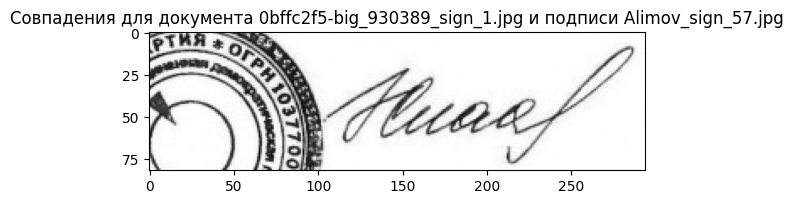

Для документа 20_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_7.jpg, 3 хороших совпадений


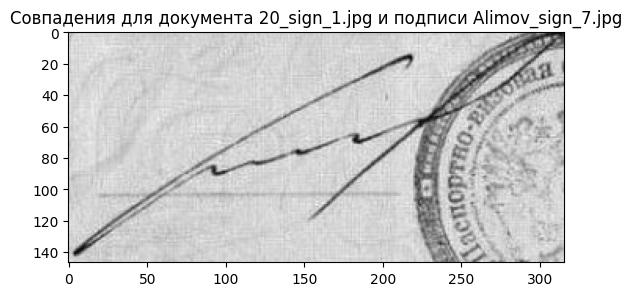

Для документа 20_sign_2.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_8.jpg, 5 хороших совпадений


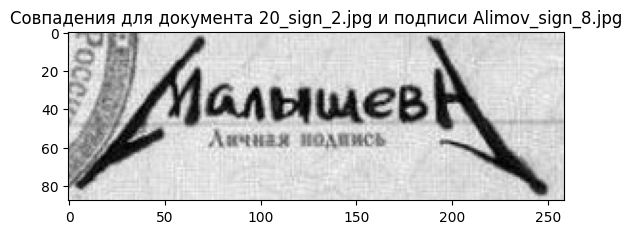

Для документа 2a391b0b-ris.-4.-zaverenie-podpisi_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_21.jpg, 1 хороших совпадений


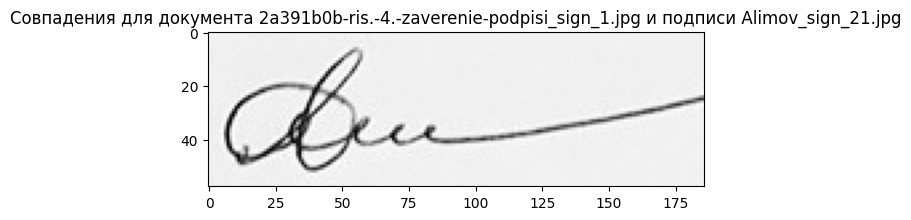

Для документа 2a391b0b-ris.-4.-zaverenie-podpisi_sign_2.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


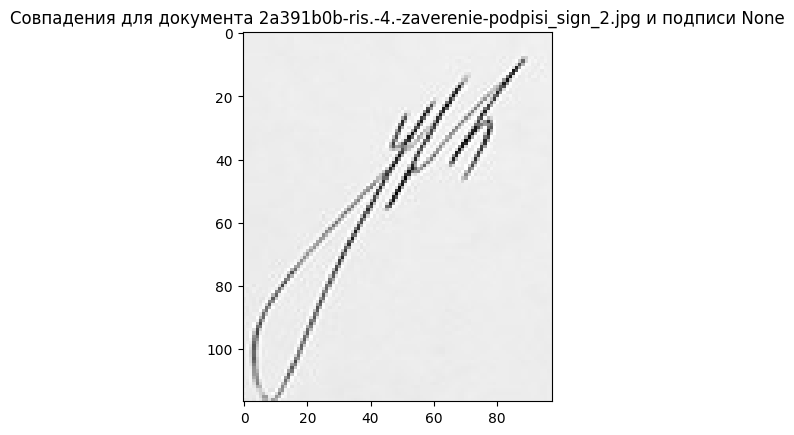

Для документа 957_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


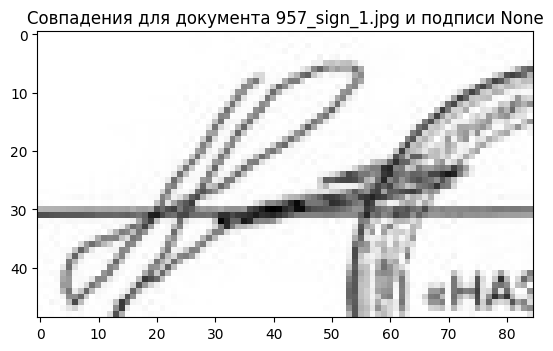

Для документа 957_sign_2.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


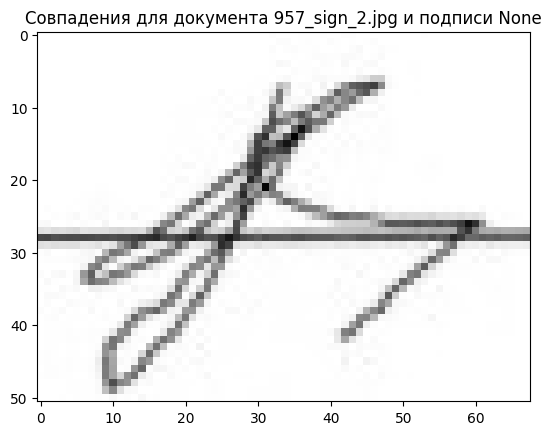

Совпадения для документа CCI_000077_sign_1.jpg и подписи Alimov_sign_7.jpg: 12 хороших совпадений


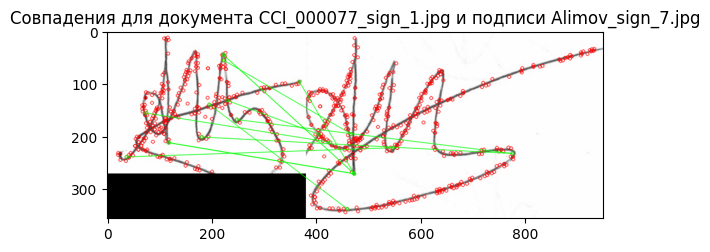

Совпадения для документа CCI_000078_sign_1.jpg и подписи Alimov_sign_21.jpg: 17 хороших совпадений


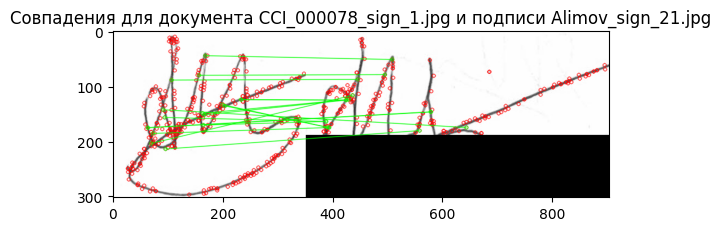

Совпадения для документа CCI_000079_sign_1.jpg и подписи Alimov_sign_11.jpg: 17 хороших совпадений


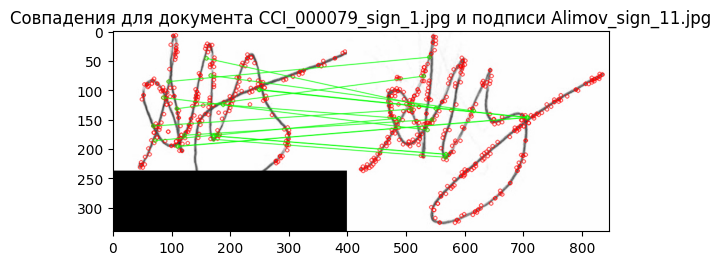

Совпадения для документа CCI_000080_sign_1.jpg и подписи Alimov_sign_28.jpg: 15 хороших совпадений


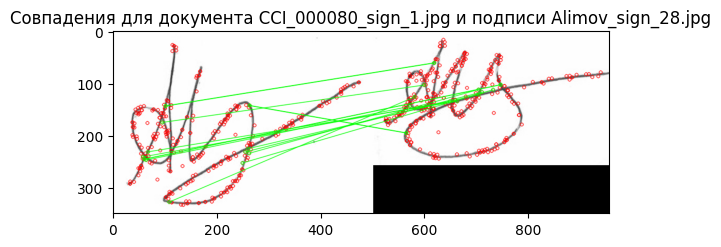

Совпадения для документа CCI_000081_sign_1.jpg и подписи Alimov_sign_27.jpg: 14 хороших совпадений


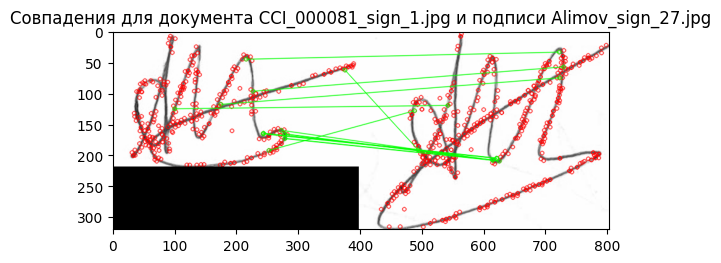

Совпадения для документа CCI_000082_sign_1.jpg и подписи Alimov_sign_20.jpg: 11 хороших совпадений


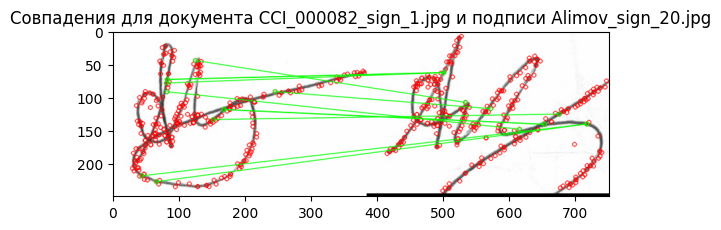

Для документа obrazec-scheta-na-oplatu-foto2024_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_4.jpg, 2 хороших совпадений


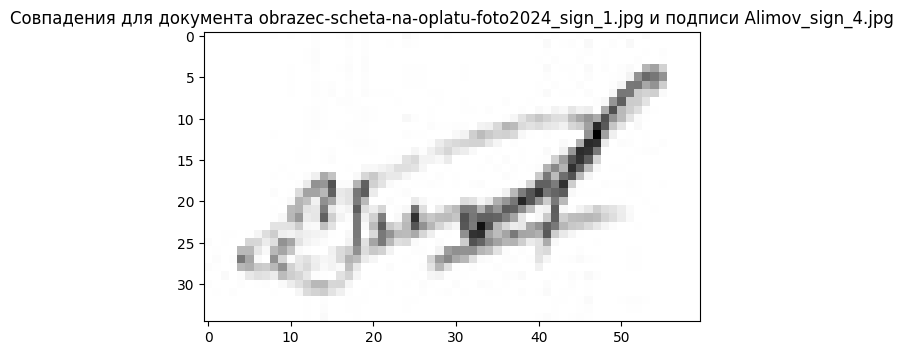

Для документа obrazec-scheta-na-oplatu-foto2024_sign_2.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


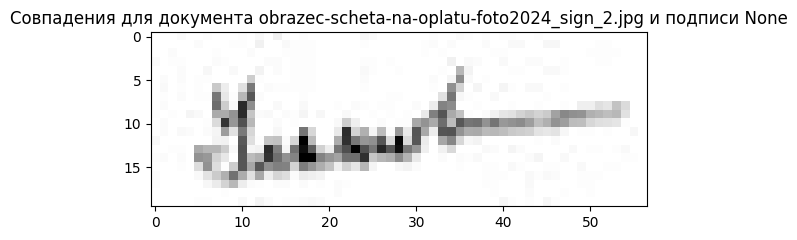

Для документа obrazec_spravki_iz_Banka_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_21.jpg, 1 хороших совпадений


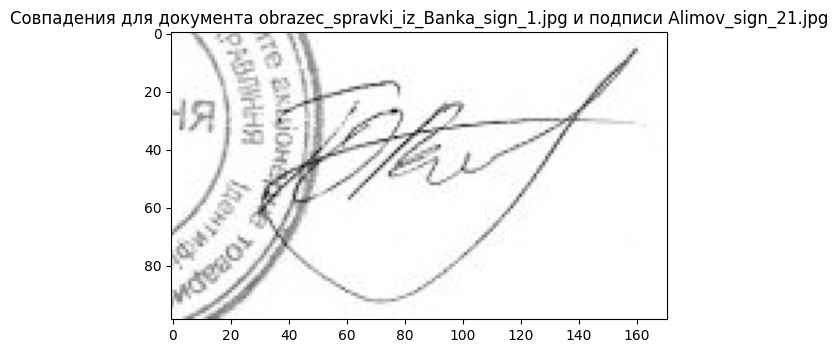

Для документа sign_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_39.jpg, 3 хороших совпадений


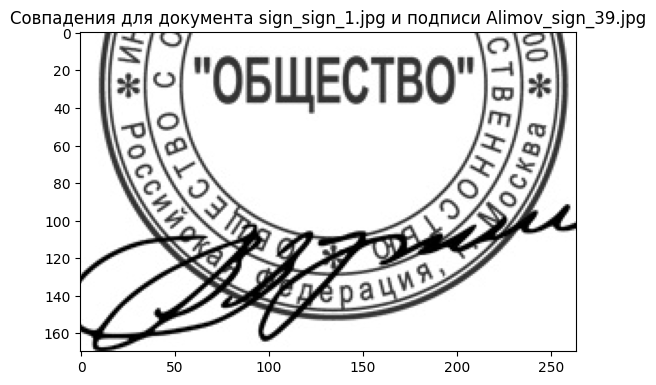

Для документа Vypiska-dlya-vizy-747x1024_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: Alimov_sign_13.jpg, 2 хороших совпадений


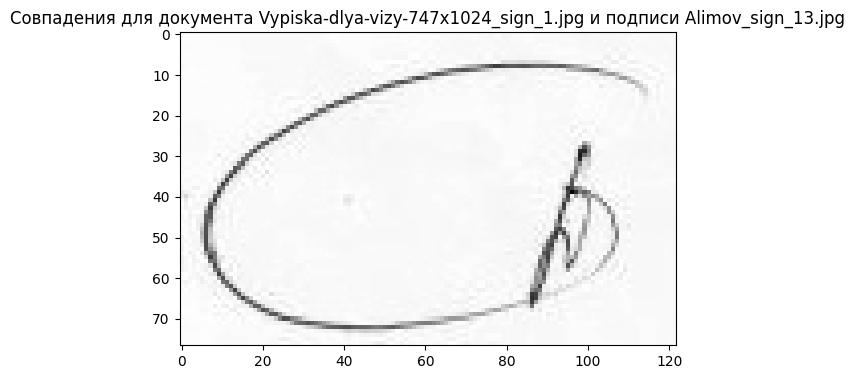

Для документа Vypiska-dlya-vizy-747x1024_sign_2.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


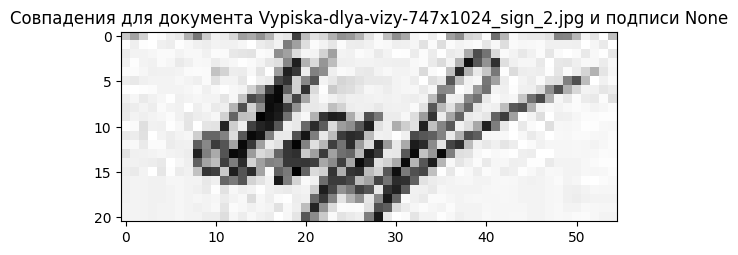

Для документа Без названия2_sign_1.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


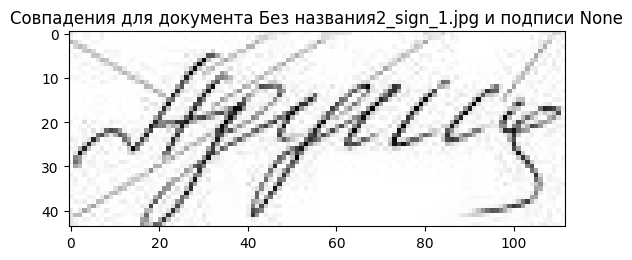

Для документа Без названия2_sign_2.jpg не найдено подходящей подписи. 
Лучшее совпадение: None, 0 хороших совпадений


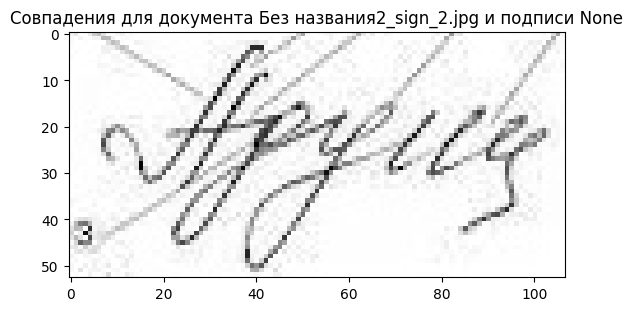

In [13]:
visualize_best_signatures(employee_signs_path + employee_name, predicts_signs_path)

# Текстовый вывод о сравнениях подписей

In [14]:
def text_output_signatures(employee_name, employee_signatures_path, predicts_path):
    # Загружаем все изображения подписей сотрудника 
    employee_signatures = []
    for filename in os.listdir(employee_signatures_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            signature_img = cv2.imread(os.path.join(employee_signatures_path, filename), cv2.IMREAD_GRAYSCALE)
            employee_signatures.append((filename, signature_img))

    # Загружаем все изображения подписей с документов
    document_signatures = []
    for filename in os.listdir(predicts_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            signature_img = cv2.imread(os.path.join(predicts_path, filename), cv2.IMREAD_GRAYSCALE)
            document_signatures.append((filename, signature_img))

    # Создаем объект sift детектора
    sift = cv2.SIFT_create()

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) 
 
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    # Пройдемся по каждому документу
    for doc_filename, doc_signature_img in document_signatures:
        # Находим keypoints и descriptors с помощью SIFT для queryImage
        kp1, des1 = sift.detectAndCompute(doc_signature_img, None)

        # Инициализируем переменные для хранения лучшего совпадения
        best_match = None
        best_match_score = 0

        # Пройдемся по каждой подписи сотрудника
        for signature_filename, signature_img in employee_signatures:
            # Находим keypoints и descriptors с помощью SIFT для trainImage
            kp2, des2 = sift.detectAndCompute(signature_img, None)

            # Выполняем сопоставление между дескрипторами изображений
            matches = flann.knnMatch(des1, des2, k=2)

            # Необходимо отрисовать только хорошие совпадения, поэтому создадим маску
            matchesMask = [[0, 0] for _ in range(len(matches))]

            # Проверим соответствие по критерию Лоу
            good_matches = 0
            for i, (m, n) in enumerate(matches):
                if m.distance < 0.57 * n.distance:
                    matchesMask[i] = [1, 0]
                    good_matches += 1

            # Обновляем лучшее совпадение, если текущее лучше
            if good_matches > best_match_score:
                best_match_score = good_matches
                best_match = signature_filename

        # Отрисовываем только хорошие совпадения
        draw_params = dict(matchColor=(0, 255, 0),
                            singlePointColor=(255, 0, 0),
                            matchesMask=matchesMask,
                            flags=cv2.DrawMatchesFlags_DEFAULT)    
        img3 = cv2.drawMatchesKnn(doc_signature_img, kp1, signature_img, kp2, matches, None, **draw_params)

        # Определяем пороговое значение для совпадения
        match_threshold = 10

        # Проверяем, превышает ли количество совпадающих особых точек пороговое значение
        if best_match_score >= match_threshold:
            print(f"Подпись на документе {doc_filename} СОВПАДАЕТ с подписью сотрудника {employee_name} ({best_match}). \nКоличество совпадающих особых точек: {best_match_score}\n")
        else:
            print(f"Подпись на документе {doc_filename} НЕ СОВПАДАЕТ с подписями сотрудника {employee_name}. \nКоличество совпадающих особых точек: {best_match_score}\n")

In [15]:
text_output_signatures(employee_name, employee_signs_path+employee_name, predicts_signs_path)

Подпись на документе 0bffc2f5-big_930389_sign_1.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 2

Подпись на документе 20_sign_1.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 3

Подпись на документе 20_sign_2.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 5

Подпись на документе 2a391b0b-ris.-4.-zaverenie-podpisi_sign_1.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 1

Подпись на документе 2a391b0b-ris.-4.-zaverenie-podpisi_sign_2.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 0

Подпись на документе 957_sign_1.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 0

Подпись на документе 957_sign_2.jpg НЕ СОВПАДАЕТ с подписями сотрудника Alimov. 
Количество совпадающих особых точек: 0

Подпись на документе CCI_000077_sign_1.jpg СОВПАДАЕТ с подписью сотрудника Al